## SARIMAX - Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors

Nas aulas anteriores analisamos modelos que consideram valores passados ​​de um conjunto de dados ​​para determinar tendências futuras, sazonalidade e valores previstos. Na aula de hoje, além de observar a tendência e a sozonaliadade, levaremos em conta também fatores externos que podem influenciar o comportamento de séries temporais.

Vamos iniciar importanto as bibliotecas necessárias e o dataset utilizado.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                              

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

### Inspecionando os dados
Nesta aula, utilizaremos um dataset de visitantes de restaurantes inspirado em uma <a href='https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting'>competição do Kaggle</a>. Os dados consideram visitantes diários de quatro restaurantes localizados nos Estados Unidos, sujeitos aos feriados americanos. Para a variável exógena veremos como os feriados afetam a quantidade de clientes. O conjunto de dados contém 478 dias de dados de restaurantes, além de 39 dias adicionais de dados de feriados para fins de previsão.

In [2]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


Observe que, embora as colunas de visitantes dos restaurantes contenham dados inteiros, elas aparecem como floats. Isso ocorre porque a parte inferior do dataframe tem 39 linhas de dados NaN para acomodar os dados extras de feriados que usaremos para previsão, e o pacote Panda não permite NaN como números inteiros. Poderíamos deixar assim, mas como temos que eliminar os valores NaN de qualquer maneira, vamos também converter as colunas para dtype int64.

In [3]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [4]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [5]:
# Mudando o dtype das colunas
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


Vamos agora plotar os dados para visualizarmos suas características.

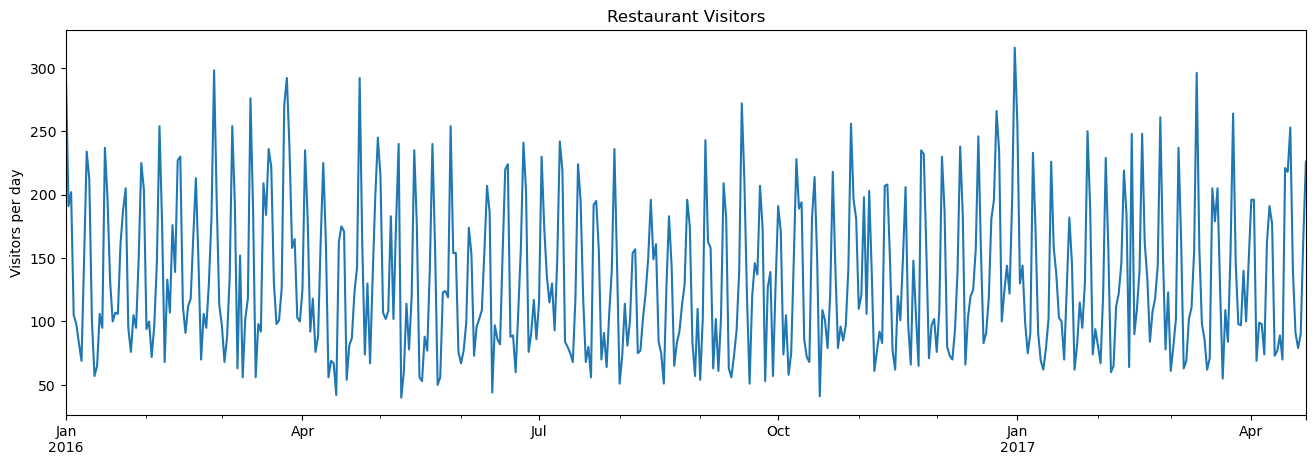

In [6]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' 

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Queremos enteder se e como os feriados influenciam o movimento dos restaurantes. Para tanto, vamos plotar uma linha para cada feriado sobre o gráfico anterior. Dessa forma, podemos obervar se os feriados têm influência no movimento dos restaurantes.

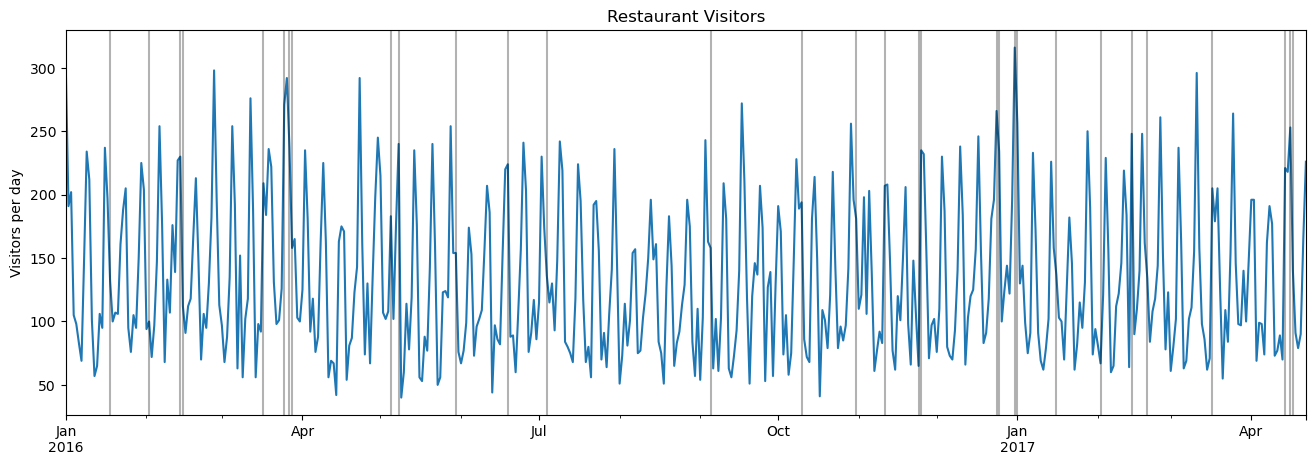

In [7]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # selecionando dias nos quais holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # adicionando uma linha cinza semi-transparente

Vamos agora fazer uma decomposição ETS para nos ajudar a enteder melhor nossos dados.

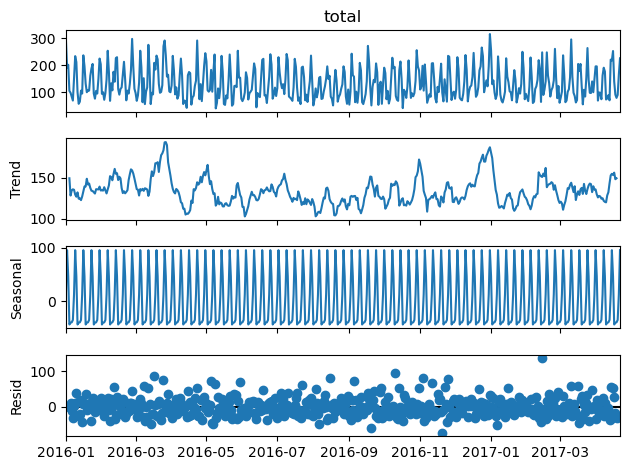

In [8]:
result = seasonal_decompose(df1['total'])
result.plot();

Vamos realizar um teste de estacionaridade.

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Evidência forte contra a hipótese nula.")
        print("Rejeitar a hipótese nula.")
        print("Dados não tem raiz unitária. Série estacionária.")
    else:
        print("Evidência fraca contra a hipótese nula.")
        print("Falha em rejeitar a hipótese nula.")
        print("Dados tem uma raiz unitária. Série não estacionária.")

In [10]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Evidência forte contra a hipótese nula.
Rejeitar a hipótese nula.
Dados não tem raiz unitária. Série estacionária.


Vamos executar o auto_arima para obter os parâmetros do modelo.

In [11]:
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2379.263
Date:                   Tue, 18 Jun 2024   AIC                           4766.525
Time:                           19:47:08   BIC                           4783.204
Sample:                       01-01-2016   HQIC                          4773.083
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9191      1.526      2.568      0.010       0.928       6.910
ar.S.L7        0.9709      0.011     86.646      0.000       0.949       0.993
ma.S.L7       -0.7861      0.047    -16.684      0.000      -0.878      -0.694
sigma2      1219.3140     71.720     17.001      0.000    1078.746    1359.882
===================================================================================
Ljung-Box (L1) (Q):                  15.66   Jarque-Bera (JB):                67.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.76
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Vamos agora dividir o dataset em treino e teste. Nosso conjunto de teste vai conter 42 dias para que diversos feriados possam estar incluídos neste período.

In [12]:
len(df1) - 42

436

In [13]:
treino = df1.iloc[:436]
teste = df1.iloc[436:]

Vamos agora ajustar um modelo SARIMA com os parâmetros obtidos: SARIMAX(1, 0, 0)x(1, 0, [1], 7).

In [14]:
model = SARIMAX(treino['total'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2155.511
Date:                             Tue, 18 Jun 2024   AIC                           4319.023
Time:                                     19:47:09   BIC                           4335.333
Sample:                                 01-01-2016   HQIC                          4325.460
                                      - 03-11-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2194      0.043      5.067      0.000       0.135       0.304
ar.S.L7        0.9999      0.000   8032.971      0.000       1.000       1.000
ma.S.L7       -0.9405      0.023    -40.032      0.000      -0.987      -0.894
sigma2      1068.8717     54.346     19.668      0.000     962.355    1175.388
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):               106.77
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.77
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# Obtendo previsões
start=len(treino)
end=len(treino)+len(teste)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(1,0,1,7) Predictions')

Vamos confrontar os valores previstos com os valores reais de teste.

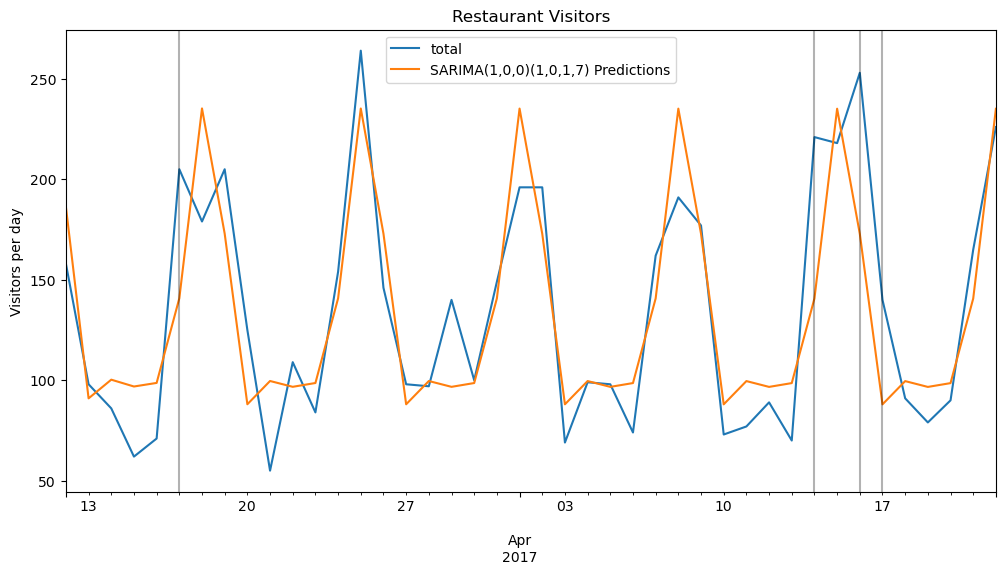

In [16]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = teste['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in teste.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

Vamos agora avaliar o modelo.

In [17]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(teste['total'], predictions)
error2 = rmse(teste['total'], predictions)

print(f'SARIMA(1,0,0)(1,0,1,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(1,0,1,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(1,0,1,7) MSE Error: 1022.058437
SARIMA(1,0,0)(1,0,1,7) RMSE Error: 31.96964869


Vamos agora adicionar a variável exógena ao modelo.

In [18]:
model = SARIMAX(treino['total'],exog=treino['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2089.208
Date:                             Tue, 18 Jun 2024   AIC                           4188.417
Time:                                     19:47:11   BIC                           4208.805
Sample:                                 01-01-2016   HQIC                          4196.463
                                      - 03-11-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.9357      3.773     18.271      0.000      61.541      76.330
ar.L1          0.2101      0.044      4.762      0.000       0.124       0.297
ar.S.L7        1.0000   5.78e-05   1.73e+04      0.000       1.000       1.000
ma.S.L7       -0.9581      0.022    -43.532      0.000      -1.001      -0.915
sigma2       779.3159     44.867     17.369      0.000     691.378     867.254
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                20.47
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.22
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Gerando a previsão.

In [19]:
exog_forecast = teste[['holiday']]  # requer colchete duplos 
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

Plotando a previsão e valores conhecidos do teste.

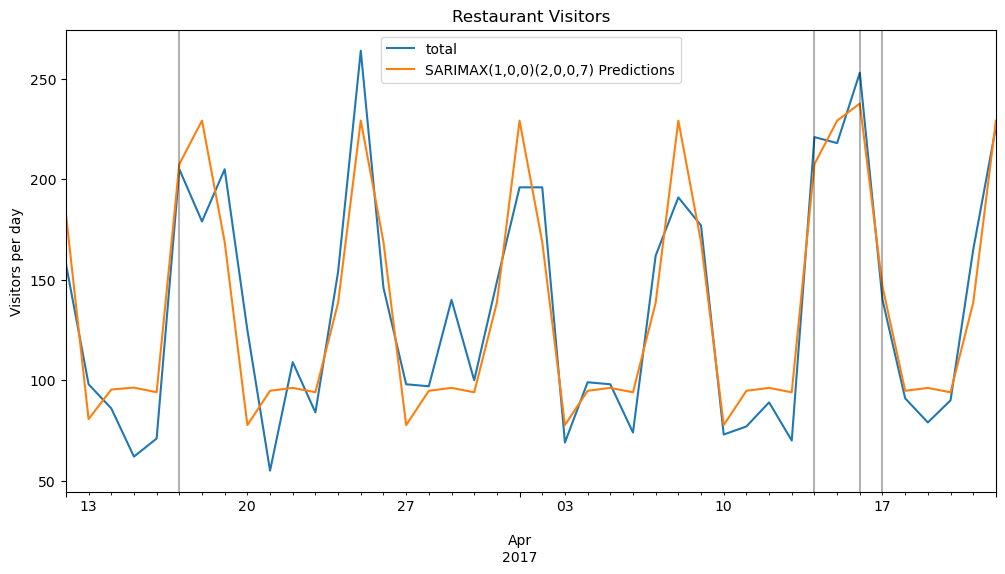

In [20]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = teste['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in teste.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

Comparando o novo modelo com o anterior.

In [21]:
# Modelo anterior
print(f'SARIMA(1,0,0)(1,0,1,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(1,0,1,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(teste['total'], predictions)
error2x = rmse(teste['total'], predictions)

# Novo modelo
print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(1,0,1,7) MSE Error: 1022.058437
SARIMA(1,0,0)(1,0,1,7) RMSE Error: 31.96964869

SARIMAX(1,0,0)(2,0,0,7) MSE Error: 525.7734395
SARIMAX(1,0,0)(2,0,0,7) RMSE Error:  22.9297501


Vamos agora retreinar nosso modelo para realizar previsões futuras. Faremos uma previsão de 39 dias no futuro e usaremos os dados adicionais de feriados.

In [22]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(1,0,1,7) Forecast')

Plotando a previsão.

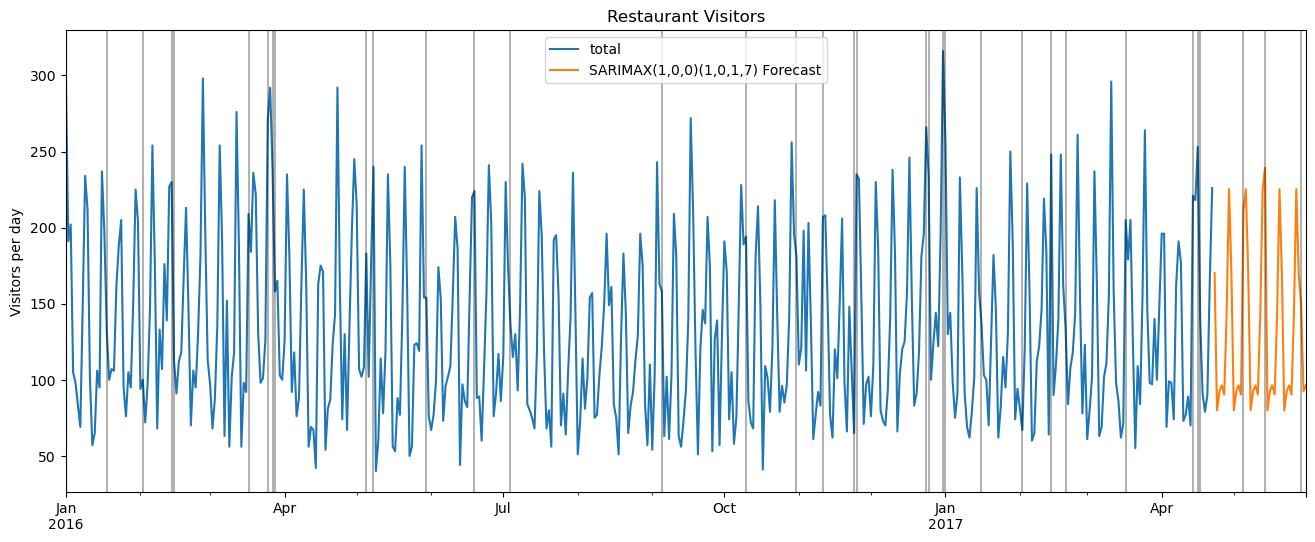

In [23]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);